# Using ICA and PCA to Predict Infection Counts

In [1]:
import numpy as np
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt

from sklearn.decomposition import FastICA, PCA

import warnings
warnings.filterwarnings("ignore") # to avoid complex number warning

#### Load in the data and prepare for analysis

In [2]:
df_weekly_symptoms = pk.load(open("weekly_symptoms(pca-ica).pkl", "rb"))
diseases = pk.load(open("weekly_diseases.pkl", "rb"))
diseases = diseases.drop(columns='Kalenderwoche')
diseases = diseases.loc[:, ('Influenza', 'Windpocken', 'Norovirus-Gastroenteritis')]

In [3]:
symptoms_data = []
disease_data = []
BREAKOFF = False
overall_week = 0

for year in range(2001,2019):
    for week in range(1, 53):
        if year == 2018:
            if week == 6:
                BREAKOFF = True
                
        if week < 10:
            week = '0'+str(week)
        else:
            week = str(week)
        
        date = str(year)+'-KW'+week
#         print("Appending:", date) # for debugging
        
        symptoms_data.append(list(df_weekly_symptoms.loc[df_weekly_symptoms['Kalenderwoche'] == date]['Anzahl'][:18]))
        disease_data.append(list(diseases.iloc[overall_week]))
        
        overall_week += 1
        
        if BREAKOFF:
            break
        

In [4]:
symptoms_data = np.asarray(symptoms_data)
disease_data = np.asarray(disease_data)

#### Explore data

In [5]:
print(symptoms_data.shape)
print(disease_data.shape)
print('Symptoms:\n', symptoms_data[0])
print('Disease:\n', disease_data[0])

(890, 18)
(890, 3)
Symptoms:
 [ 0 10  0  0  0  0  0  3  0  2  1  0  0  0  0  0  1  0]
Disease:
 [  7   0 136]


#### Compute ICs and fit

In [6]:
ica = FastICA(n_components=disease_data.shape[1])#, whiten=False)
S_ = ica.fit_transform(symptoms_data)  # Reconstruct signals

#### Compute Pcs and fit, as well as eigenvalues

In [7]:
pca = PCA(n_components=disease_data.shape[1], whiten=False)
pca_done = pca.fit_transform(symptoms_data)
print(pca_done.shape)

(890, 3)


In [8]:
cov = pca.get_covariance()
eig = np.linalg.eig(cov)

## Results
ICA did not return a good model of the data, but PCA seemed to create a good match.  We then plotted the eigenvalues to see how well they were describing the data, and saw that the first principal compenent accounted for much of the data.  

We then decided to cut out the first principle component to examine things further.

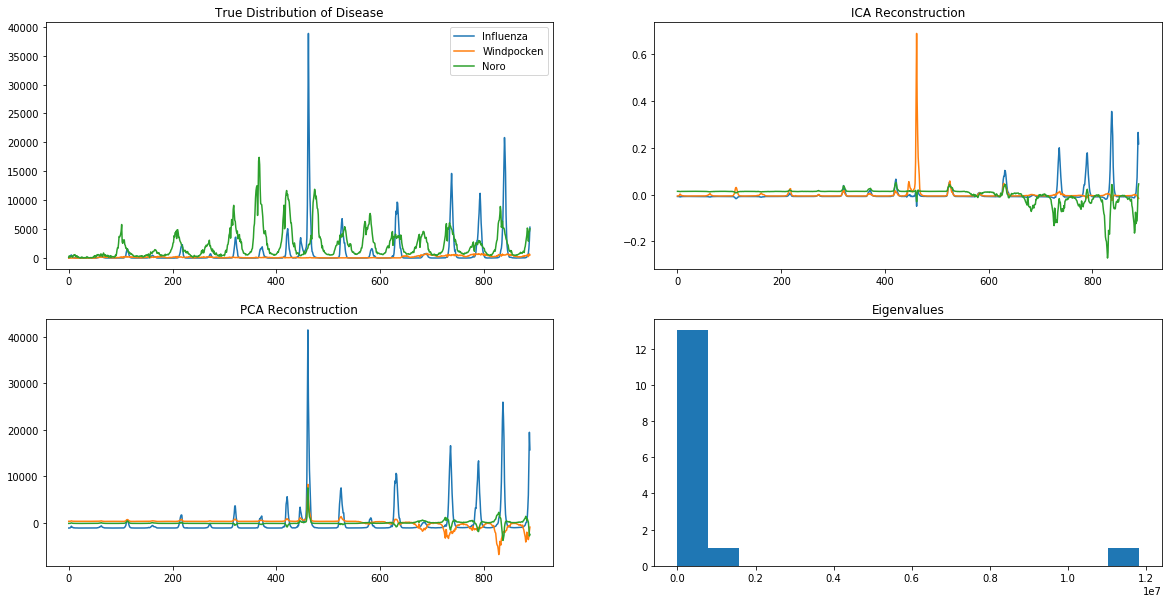

In [9]:
bottom = 455
top = 470
zoom = False

f, axarr = plt.subplots(2, 2, figsize=(20, 10))
f.size=((20,20))

axarr[0, 0].plot(disease_data.T[0], label='Influenza')
axarr[0, 0].plot(disease_data.T[1], label='Windpocken')
axarr[0, 0].plot(disease_data.T[2], label='Noro')
if zoom: axarr[0, 0].set_xlim([bottom,top])
axarr[0, 0].legend()
axarr[0, 0].set_title('True Distribution of Disease')

axarr[0, 1].plot(S_)
if zoom: axarr[0, 1].set_xlim([bottom,top])
axarr[0, 1].set_title('ICA Reconstruction')

axarr[1, 0].plot(pca_done)
if zoom: axarr[1, 0].set_xlim([bottom,top])
axarr[1, 0].set_title('PCA Reconstruction')

axarr[1, 1].hist(eig[0][:15], bins=15)
axarr[1, 1].set_title('Eigenvalues')

plt.show()

Upon further thought, we realized PCA and other such algorithms don't work with time series data.

# Further Work:
We saw extreme periodicity in the disease data, so we figured why not throw an LSTM at it!